# ICSC Paper Data
This file aims to lay out, completely and in a self-contained location, all data that is needed to present the findings of the ICSC paper, exceept for the runs of the TWIG NN (which are in `../rec_construct_1/`). Sections describe the major point being shown.

## UMLS has high MRR --> MRR correlation across random seeds

In [1]:
#Note: UMLS 1 actually had diff rand seeds for each exp like UMLS2, etc
from utils import gather_data
dataset_name = 'UMLS'
exp_dirs = [
    '../output/UMLS/UMLS-TWM-run2.1/',
    '../output/UMLS/UMLS-TWM-run2.2/',
    '../output/UMLS/UMLS-TWM-run2.3/',
    '../output/UMLS/UMLS-TWM-run2.4/'
]
exp_to_mrrs = {}
for exp_dir in exp_dirs:
    print(f'{exp_dir}')
    overall_results, \
            triples_results, \
            grid, \
            valid_triples_map, \
            graph_stats = gather_data(dataset_name, exp_dir)
    mrrs = []
    for exp_id in dict(sorted(overall_results.items())):
        mrr = overall_results[exp_id]['mrr']
        mrrs.append(mrr)
    exp_to_mrrs[exp_dir] = mrrs

/root/miniconda3/envs/twig/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


../output/UMLS/UMLS-TWM-run2.1/
../output/UMLS/UMLS-TWM-run2.2/
../output/UMLS/UMLS-TWM-run2.3/
../output/UMLS/UMLS-TWM-run2.4/


In [2]:
from scipy.stats import pearsonr
for i in range(len(exp_dirs)):
    for j in range(i+1, len(exp_dirs)):
        print(f'{exp_dirs[i]} vs {exp_dirs[j]}')
        r, p = pearsonr(exp_to_mrrs[exp_dirs[i]], exp_to_mrrs[exp_dirs[j]])
        print(f'r = {round(r, 4)}, p = {p}')
        print()

../output/UMLS/UMLS-TWM-run2.1/ vs ../output/UMLS/UMLS-TWM-run2.2/
r = 0.994, p = 0.0

../output/UMLS/UMLS-TWM-run2.1/ vs ../output/UMLS/UMLS-TWM-run2.3/
r = 0.9945, p = 0.0

../output/UMLS/UMLS-TWM-run2.1/ vs ../output/UMLS/UMLS-TWM-run2.4/
r = 0.9939, p = 0.0

../output/UMLS/UMLS-TWM-run2.2/ vs ../output/UMLS/UMLS-TWM-run2.3/
r = 0.995, p = 0.0

../output/UMLS/UMLS-TWM-run2.2/ vs ../output/UMLS/UMLS-TWM-run2.4/
r = 0.9943, p = 0.0

../output/UMLS/UMLS-TWM-run2.3/ vs ../output/UMLS/UMLS-TWM-run2.4/
r = 0.9951, p = 0.0



## Ranked lists have low KL Divergence across random seeds when hyperparameters are equivalent

In [51]:
from scipy.special import kl_div
import glob
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import numpy as np

def get_ranks_lists(exp_dir, combine=True):
    results_file = glob.glob(os.path.join(exp_dir, '*.res'))[0]

    with open(results_file, 'r') as res:
        curr_exp = 0
        curr_section = None
        rank_results = {}
        for line in res:
            if 'End of exp ' in line:
                curr_exp = int(line.strip().replace('End of exp ', ''))
                rank_results[curr_exp] = {} if not combine else []
            elif 'Head ranks: (idx, rank)' in line:
                curr_section = 'HEAD'
            elif 'Tail ranks: (idx, rank)' in line:
                curr_section = 'TAIL'
            elif line.strip() == '':
                curr_section = None

            if ' --> ' in line:
                idx, rank = line.strip().split(' --> ')
                idx = int(idx)
                rank = float(rank)
                if curr_section == 'HEAD' or curr_section == 'TAIL':
                    if combine:
                        rank_results[curr_exp].append(rank)
                    else:
                        if not curr_section in rank_results[curr_exp]:
                            rank_results[curr_exp][curr_section] = []
                        rank_results[curr_exp][curr_section].append(rank)
                else:
                    assert False, 'This should be impossible'

    return dict(sorted(rank_results.items()))

def get_pairwise_kl_div(exp_ranks_1, exp_ranks_2, bins=30):
    run_id_to_kl_div = {}
    for run_id in exp_ranks_1:
        r1 = torch.tensor(exp_ranks_1[run_id])
        r2 = torch.tensor(exp_ranks_2[run_id])
        bin_min = r1.min()
        bin_max = r1.max()
        d1 = torch.histc(r1, bins=bins, min=bin_min, max=bin_max) + 1 #numerical stability
        d1 = d1 / torch.sum(d1)

        d2 = torch.histc(r2, bins=bins, min=bin_min, max=bin_max) + 1 #numerical stability
        d2 = d2 / torch.sum(d2)
        
        kl_val = torch.sum(kl_div(d1, d2))
        run_id_to_kl_div[run_id] = float(kl_val)
    return dict(sorted(run_id_to_kl_div.items()))

def do_hist(data, bins=30, x_min=None, x_max=None):
    fig, ax = plt.subplots()
    sns.histplot(data, bins=bins, ax=ax)  # distplot is deprecate and replaced by histplot
    ax.set_xlim(x_min, x_max)
    plt.show()

def do_numeric_summary(data):
    if type(data) == dict:
        data = list(data.values())
    print(f'mean = {round(np.mean(data), 4)}, std = {round(np.std(data), 4)}')

../output/UMLS/UMLS-TWM-run2.1/ vs ../output/UMLS/UMLS-TWM-run2.2/


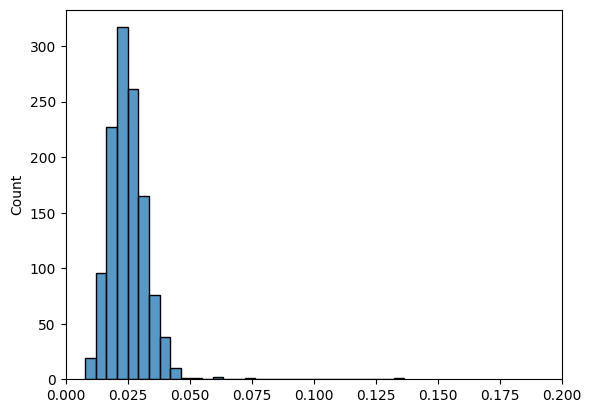

mean = 0.025020142477542286, std = 0.007709457016497616
../output/UMLS/UMLS-TWM-run2.1/ vs ../output/UMLS/UMLS-TWM-run2.3/


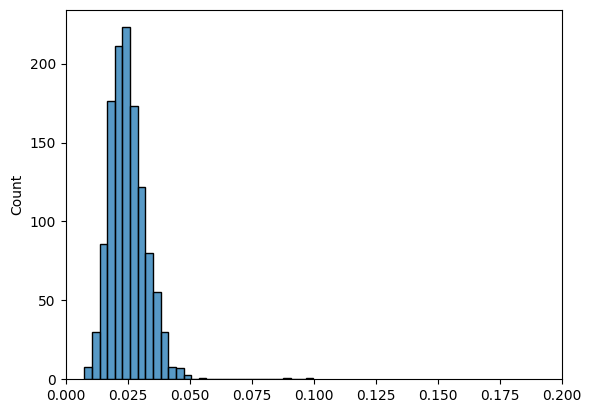

mean = 0.02499786614145271, std = 0.007516748282645473
../output/UMLS/UMLS-TWM-run2.1/ vs ../output/UMLS/UMLS-TWM-run2.4/


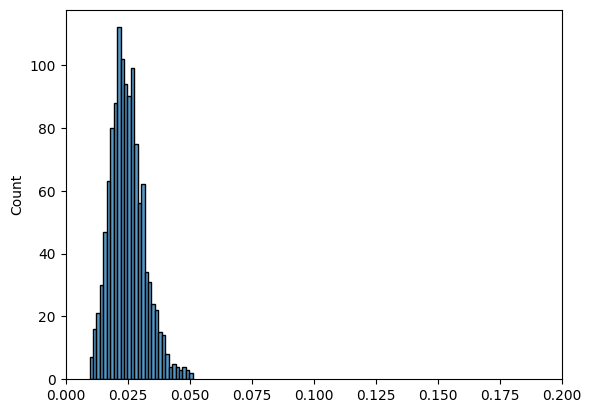

mean = 0.024830511682226088, std = 0.00696441003685705
../output/UMLS/UMLS-TWM-run2.2/ vs ../output/UMLS/UMLS-TWM-run2.3/


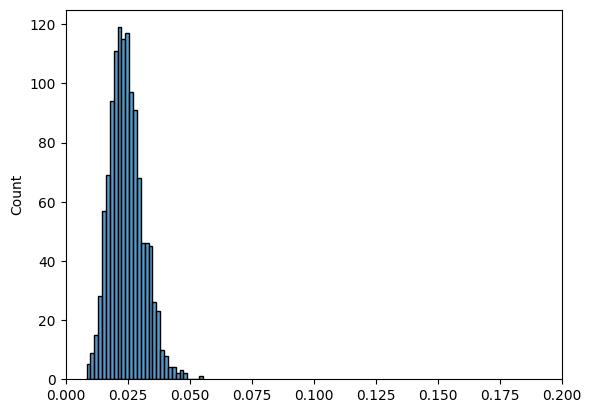

mean = 0.02446145352221443, std = 0.006659447794660052
../output/UMLS/UMLS-TWM-run2.2/ vs ../output/UMLS/UMLS-TWM-run2.4/


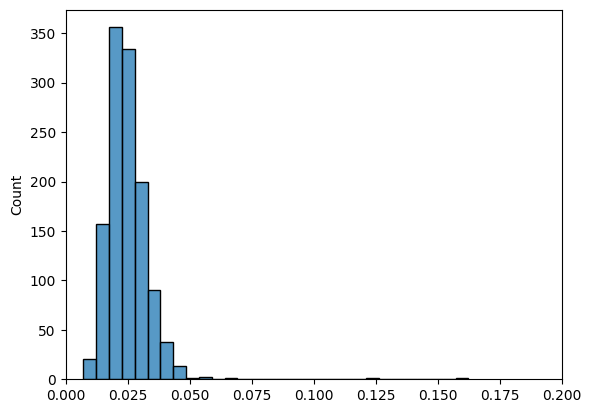

mean = 0.024838715317225996, std = 0.008668631032438298
../output/UMLS/UMLS-TWM-run2.3/ vs ../output/UMLS/UMLS-TWM-run2.4/


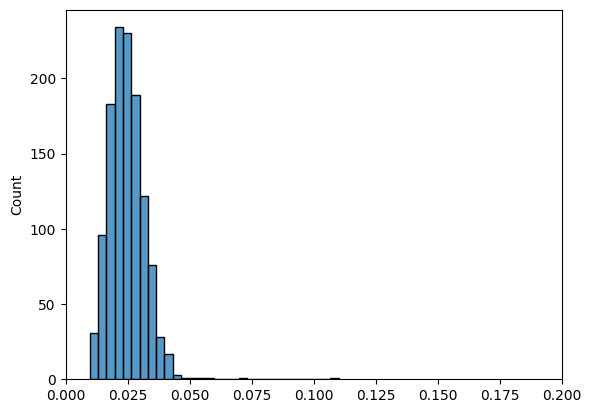

mean = 0.024665318945338452, std = 0.0072701277217142


In [17]:
rank_lists = {
    loc : get_ranks_lists(loc) for loc in exp_dirs
}
bins = 30

for i in range(len(exp_dirs)):
    for j in range(i+1, len(exp_dirs)):
        print(f'{exp_dirs[i]} vs {exp_dirs[j]}')
        kl_vals = get_pairwise_kl_div(
            rank_lists[exp_dirs[i]],
            rank_lists[exp_dirs[j]]
        )
        do_hist(kl_vals, bins=bins, x_min=0, x_max=0.2)
        do_numeric_summary(kl_vals)

## Ranked lists have higher KL Divergence across random seeds when hyperparameters are different

In [40]:
def get_pairwise_kl_div_diff_hps(exp_ranks_1, exp_ranks_2, bins=30):
    run_id_pair_to_kl_div = {}
    for run_id in exp_ranks_1:
        for run_id_2 in set(exp_ranks_2) - {run_id}:
            r1 = torch.tensor(exp_ranks_1[run_id])
            r2 = torch.tensor(exp_ranks_2[run_id_2])
            bin_min = r1.min()
            bin_max = r1.max()
            d1 = torch.histc(r1, bins=bins, min=bin_min, max=bin_max) + 1 #numerical stability
            d1 = d1 / torch.sum(d1)

            d2 = torch.histc(r2, bins=bins, min=bin_min, max=bin_max) + 1 #numerical stability
            d2 = d2 / torch.sum(d2)
            
            kl_val = torch.sum(kl_div(d1, d2))
            run_id_pair_to_kl_div[(run_id, run_id_2)] = float(kl_val)
    return dict(sorted(run_id_pair_to_kl_div.items()))

In [43]:
pairwise_kl_vals_all = {}
for i in range(len(exp_dirs)):
    for j in range(i+1, len(exp_dirs)):
        print(f'{exp_dirs[i]} vs {exp_dirs[j]}')
        pairwise_kl_vals = get_pairwise_kl_div_diff_hps(
            rank_lists[exp_dirs[i]],
            rank_lists[exp_dirs[j]]
        )
        pairwise_kl_vals_all[(exp_dirs[i], exp_dirs[j])] = pairwise_kl_vals

../output/UMLS/UMLS-TWM-run2.1/ vs ../output/UMLS/UMLS-TWM-run2.2/
../output/UMLS/UMLS-TWM-run2.1/ vs ../output/UMLS/UMLS-TWM-run2.3/
../output/UMLS/UMLS-TWM-run2.1/ vs ../output/UMLS/UMLS-TWM-run2.4/
../output/UMLS/UMLS-TWM-run2.2/ vs ../output/UMLS/UMLS-TWM-run2.3/
../output/UMLS/UMLS-TWM-run2.2/ vs ../output/UMLS/UMLS-TWM-run2.4/
../output/UMLS/UMLS-TWM-run2.3/ vs ../output/UMLS/UMLS-TWM-run2.4/


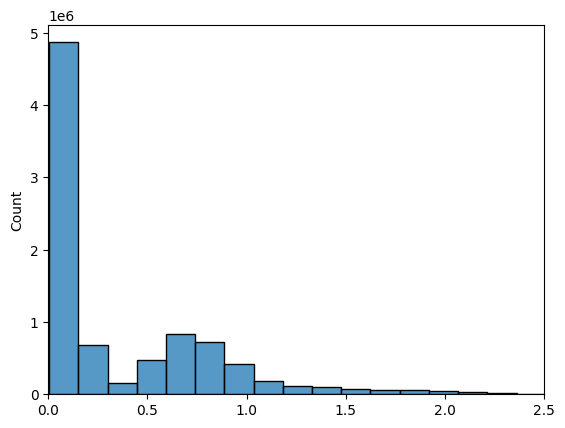

mean = 0.3632, std = 0.4637


In [52]:
kl_all_list = []
for exp_id_keys in pairwise_kl_vals_all:
    for run_id_keys in pairwise_kl_vals_all[exp_id_keys]:
        kl_all_list.append(pairwise_kl_vals_all[exp_id_keys][run_id_keys])
do_hist(kl_all_list, bins=30, x_min=0, x_max=2.5)
do_numeric_summary(kl_all_list)

## Ranked lists --> rank list correlation is low

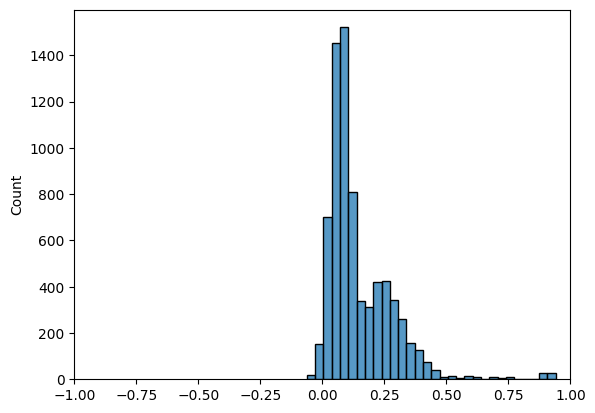

In [32]:
corrs = []
for i in range(len(exp_dirs)):
    for j in range(i+1, len(exp_dirs)):
        # print(f'{exp_dirs[i]} vs {exp_dirs[j]}')
        for exp_id in rank_lists[key]:
            # print(f'ranked list for exp_id {exp_id}')
            r, p = pearsonr(rank_lists[exp_dirs[i]][exp_id], rank_lists[exp_dirs[j]][exp_id])
            corrs.append(r)
            # print(f'r = {round(r, 4)}, p = {p}')
            # print()

do_hist(corrs, bins=30, x_min=-1, x_max=1)